# Lezione 12 - Deep Learning: CNN per Classificazione Immagini

# DEEP LEARNING: CNN PER CLASSIFICAZIONE
---

In questa lezione utilizziamo **Deep Neural Networks (DNN)** e **Convolutional Neural Networks (CNN)** per creare classificatori di immagini usando il dataset **MNIST**.

### Obiettivi della Lezione
- **Implementare** una DNN per classificazione di cifre
- **Confrontare** diversi ottimizzatori (SGD, Adadelta, Adamax)
- **Costruire** una CNN per migliorare le performance
- **Testare** i modelli su immagini custom create manualmente

---

### Dataset MNIST

#### Caratteristiche del Dataset
- **70.000 immagini** di cifre scritte a mano (0-9)
- **28×28 pixel** per immagine in scala di grigi
- **Valori pixel**: 0-255 (0=bianco, 255=nero)
- **Task**: classificazione multiclasse (10 categorie)
- **Split**: 60.000 training + 10.000 test

#### Preprocessing Standard
- **Normalizzazione**: pixel values [0,255] → [0,1]
- **Reshape**: (28,28) → (784,) per DNN | (28,28,1) per CNN
- **One-hot encoding**: labels categorici per softmax output

---

## Architetture Neurali: DNN vs CNN

#### Deep Neural Networks (DNN)
- **Fully Connected Layers**: ogni neurone connesso a tutti i precedenti
- **Flatten Input**: immagini convertite in vettori 1D
- **Vantaggi**: semplici da implementare, buone per pattern globali
- **Svantaggi**: ignorano struttura spaziale, molti parametri

#### Convolutional Neural Networks (CNN)
- **Conv2D Layers**: filtri condivisi per estrarre feature locali
- **Pooling Layers**: riduzione dimensionalità preservando info importante
- **Vantaggi**: locality, translation invariance, parameter sharing
- **Svantaggi**: più complesse da progettare e ottimizzare

In [2]:
# Configurazione environment
import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'  # Uncomment se necessario su macOS

# Importazioni principali
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Configurazione riproducibilità
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

### Caricamento e Preprocessing Dataset MNIST

Carichiamo il dataset MNIST e prepariamo i dati per l'addestramento:

Caricamento dataset MNIST...
Dataset caricato:
   • Training samples: 60,000
   • Test samples: 10,000
   • Image shape: (28, 28) pixels
   • Value range: [0, 255]
 Preprocessing completato:
   • Input shape DNN: (60000, 784)
   • Output shape: (60000, 10)
   • Pixel range: [0.0, 1.0]
   • Example label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] (one-hot)


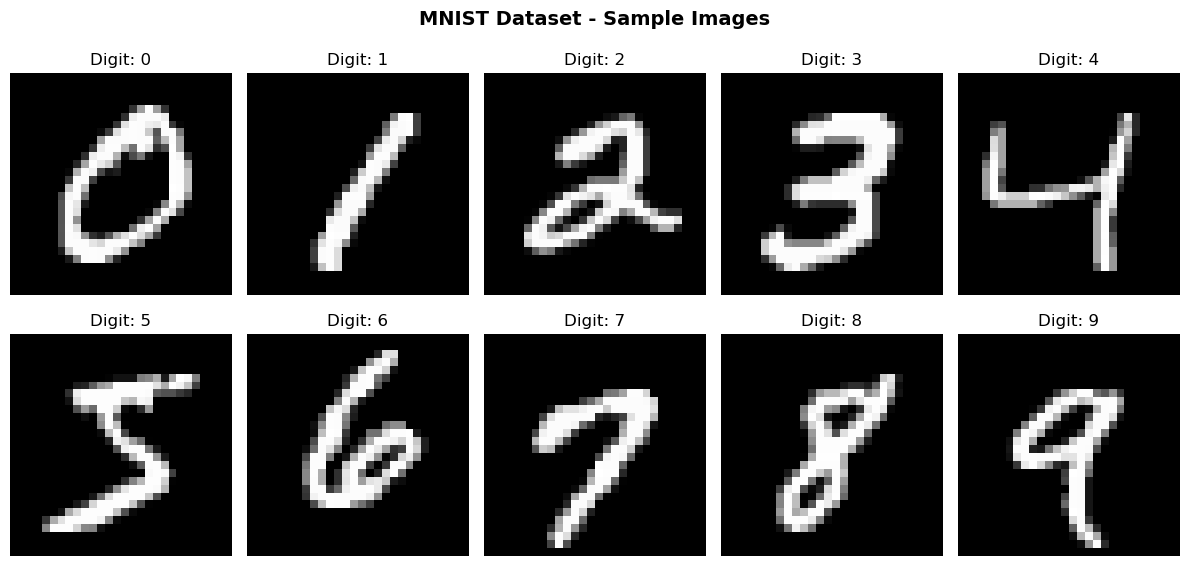

In [4]:
from keras.datasets import mnist

# Configurazione dimensioni e classi
img_rows, img_cols = 28, 28  # dimensioni immagine
num_classes = 10             # cifre 0-9

print("Caricamento dataset MNIST...")

# Caricamento dataset (già suddiviso train/test)
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(f"Dataset caricato:")
print(f"   • Training samples: {X_train.shape[0]:,}")
print(f"   • Test samples: {X_test.shape[0]:,}")
print(f"   • Image shape: {X_train.shape[1:]} pixels")
print(f"   • Value range: [{X_train.min()}, {X_train.max()}]")

# Preprocessing per DNN: reshape da (28,28) a vettore (784,)
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# Conversione a float32 per efficienza computazionale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalizzazione: [0,255] → [0,1]
X_train /= 255.0
X_test /= 255.0

# Conversione label a categorical (one-hot encoding) per softmax
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

print(f" Preprocessing completato:")
print(f"   • Input shape DNN: {X_train.shape}")
print(f"   • Output shape: {Y_train.shape}")
print(f"   • Pixel range: [{X_train.min():.1f}, {X_train.max():.1f}]")
print(f"   • Example label: {Y_train[0]} (one-hot)")

# Visualizzazione sample del dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    # Trova prima occorrenza della cifra i
    idx = np.where(np.argmax(Y_train, axis=1) == i)[0][0]
    img = X_train[idx].reshape(28, 28)
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Digit: {i}', fontsize=12)
    axes[i].axis('off')

plt.suptitle('MNIST Dataset - Sample Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## Esercizio 12.1: Deep Neural Network e Confronto Ottimizzatori

### Architettura DNN e Configurazione Ottimizzatori

Implementiamo una **Deep Neural Network** e confrontiamo diversi algoritmi di ottimizzazione:

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adadelta, Adamax
import matplotlib.pyplot as plt
import keras
import numpy as np

def create_DNN():
    """
    Architettura DNN per classificazione MNIST:
    - Layer 1: 400 neuroni ReLU (pattern recognition)
    - Layer 2: 100 neuroni ReLU (feature combining)
    - Dropout: 50% per prevenire overfitting
    - Output: 10 neuroni softmax (classificazione)
    """
    model = Sequential([
        Dense(400, input_shape=(img_rows*img_cols,), activation='relu', name='hidden_1'),
        Dense(100, activation='relu', name='hidden_2'),
        Dropout(0.5, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])
    return model

# Configurazione ottimizzatori da confrontare
optimizers = [
    ('SGD', SGD(learning_rate=0.01)),
    ('Adadelta', Adadelta()),
    ('Adamax', Adamax())
]

print(f"🏗️ Architettura DNN configurata:")
print(f"   • Input: {img_rows*img_cols} features (28×28 flattened)")
print(f"   • Hidden 1: 400 neuroni ReLU")
print(f"   • Hidden 2: 100 neuroni ReLU") 
print(f"   • Dropout: 0.5 (50% neurons disabled)")
print(f"   • Output: {num_classes} neuroni softmax")
print(f"   • Ottimizzatori: {[name for name, _ in optimizers]}")

# Stima parametri
total_params = (img_rows*img_cols + 1) * 400 + (400 + 1) * 100 + (100 + 1) * num_classes
print(f"   • Parametri stimati: {total_params:,}")

🏗️ Architettura DNN configurata:
   • Input: 784 features (28×28 flattened)
   • Hidden 1: 400 neuroni ReLU
   • Hidden 2: 100 neuroni ReLU
   • Dropout: 0.5 (50% neurons disabled)
   • Output: 10 neuroni softmax
   • Ottimizzatori: ['SGD', 'Adadelta', 'Adamax']
   • Parametri stimati: 355,110


### Configurazione Training

Impostiamo i parametri di addestramento per il confronto degli ottimizzatori:

In [9]:
# Parametri di training
batch_size = 32  # samples per batch per SGD
epochs = 30      # numero di epoche di training

print(f" Configurazione Training:")
print(f"   • Batch size: {batch_size}")
print(f"   • Epochs: {epochs}")
print(f"   • Total batches per epoch: {len(X_train) // batch_size}")
print(f"   • Loss function: categorical_crossentropy")
print(f"   • Metrics: accuracy")

 Configurazione Training:
   • Batch size: 32
   • Epochs: 30
   • Total batches per epoch: 1875
   • Loss function: categorical_crossentropy
   • Metrics: accuracy


### Training e Confronto Ottimizzatori

Addestriamo modelli identici con diversi ottimizzatori per confrontarne le performance:


Training con ottimizzatore: SGD


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Risultati con SGD:
- Loss: 0.0669
- Accuracy: 0.9799
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step


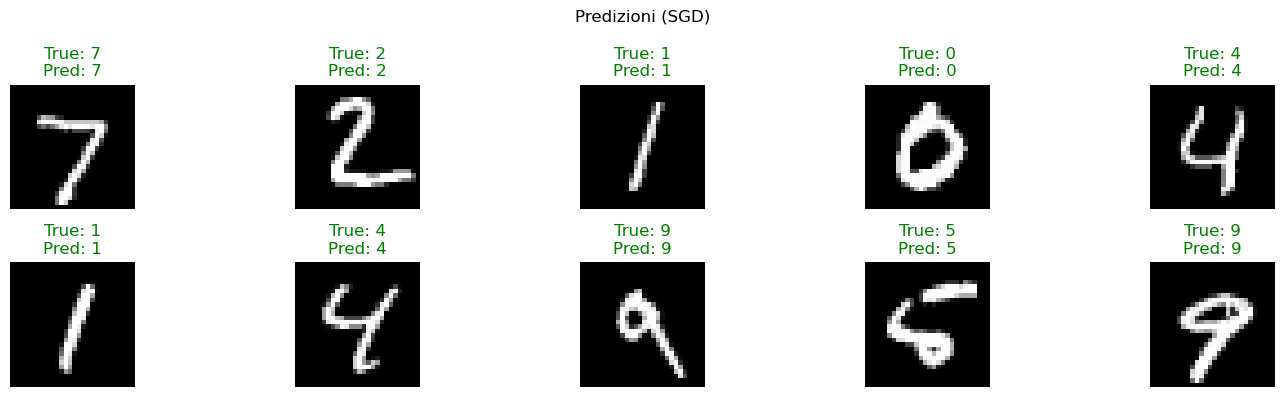


Training con ottimizzatore: Adadelta

Risultati con Adadelta:
- Loss: 0.4356
- Accuracy: 0.8959
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


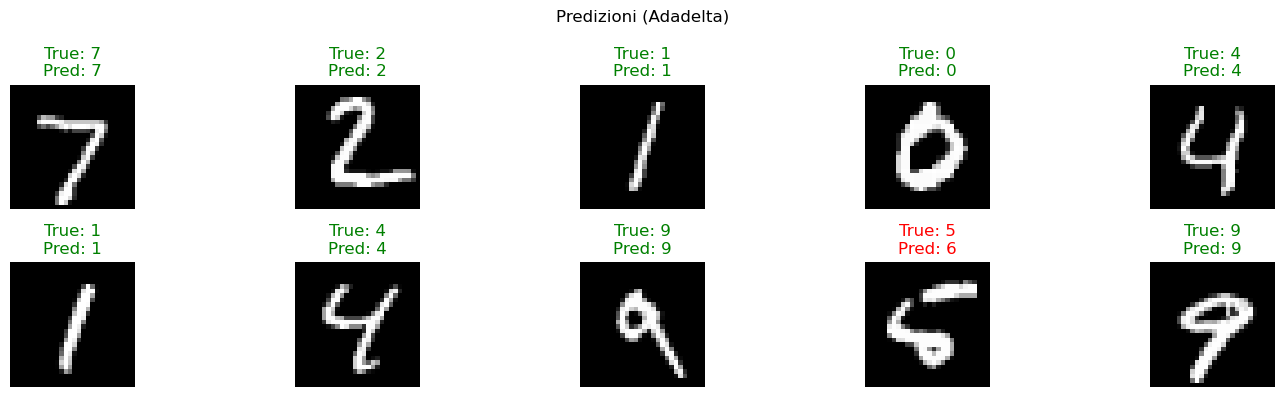


Training con ottimizzatore: Adamax

Risultati con Adamax:
- Loss: 0.0685
- Accuracy: 0.9835
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


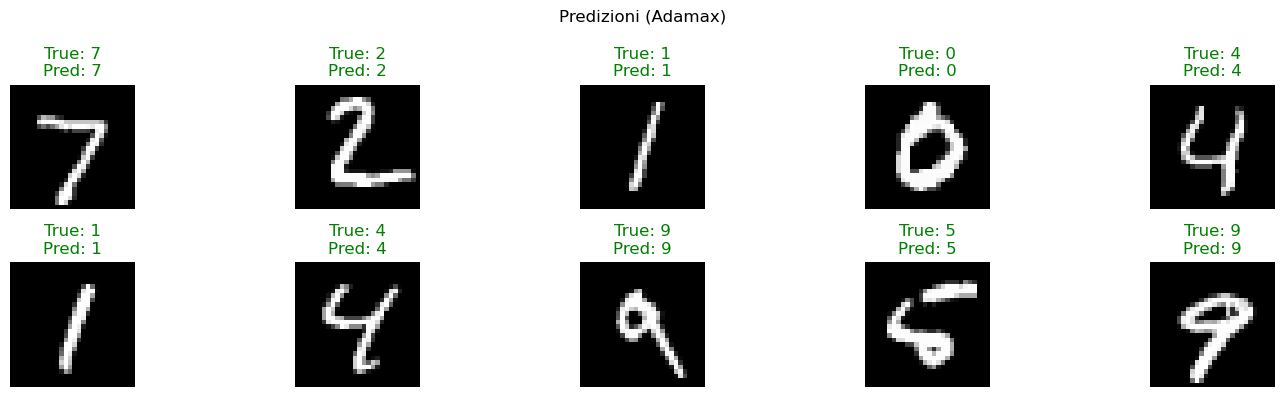

In [11]:
histories = {}

for opt_name, optimizer in optimizers:
    print(f"\n{'='*60}")
    print(f"Training con ottimizzatore: {opt_name}")
    print(f"{'='*60}")
    
    # Creazione e compilazione modello
    model = create_DNN()
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    
    # Addestramento
    history = model.fit(X_train, Y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       shuffle=True,
                       verbose=0,
                       validation_data=(X_test, Y_test))
    
    # Salvataggio storia
    histories[opt_name] = history

    # Valutazione
    score = model.evaluate(X_test, Y_test, verbose=0)
    print(f"\nRisultati con {opt_name}:")
    print(f"- Loss: {score[0]:.4f}")
    print(f"- Accuracy: {score[1]:.4f}")
    
    # Predizioni su X_test
    predictions = model.predict(X_test)
    
    # Visualizzazione prime 10 immagini con predizione
    X_test_vis = X_test.reshape(X_test.shape[0], img_rows, img_cols)

    plt.figure(figsize=(15, 4))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(X_test_vis[i], cmap='gray')
        true_label = np.argmax(Y_test[i])
        predicted_label = np.argmax(predictions[i])
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f'True: {true_label}\nPred: {predicted_label}', color=color)
        plt.axis('off')
    plt.suptitle(f'Predizioni ({opt_name})')
    plt.tight_layout()
    plt.show()

  

# Ottimizzatori per Deep Learning

## SGD (Stochastic Gradient Descent)
**Def**: Ottimizzatore classico che aggiorna i pesi nella direzione opposta (descent) al gradiente.

**Pro**: 
- Semplice e intuitivo
- Generalizza bene

**Contro**:
- Lento nella convergenza
- Sensibile alla scelta del learning rate

## Adadelta
**Definizione**: Estensione di Adagrad che adatta il learning rate in base a un window di gradienti precedenti.

**Pro**:
- Learning rate adattivo automatico
- Non richiede learning rate di default

**Contro**:
- Può convergere più lentamente di altri metodi adattivi
- Maggiore complessità computazionale

## Adagrad

**Definizione**: Adatta il learning rate per ogni parametro in base alla frequenza degli aggiornamenti.

**Pro**:

- Learning rate adattivo per ogni parametro
- Ottimo per dati sparsi

Contro:

- Learning rate diminuisce troppo aggressivamente
- Può smettere di apprendere prematuramente

## Adamax
**Definizione**: Variante di Adam basata sulla norma infinito, più stabile in alcuni casi.

**Pro**:
- Meno sensibile ai parametri
- Buone performance su problemi sparsi
- Memory efficient

**Contro**:
- Può occasionalmente convergere a soluzioni subottimali
- Più parametri da regolare rispetto a SGD

## Adam (Adaptive Moment Estimation)
**Definizione**: Combina i vantaggi di RMSProp e Momentum, utilizzando stime dei primi e secondi momenti dei gradienti.

**Pro**:
- Elevata efficienza computazionale
- Learning rate adattivo per ogni parametro

**Contro**:
- Può convergere a minimi locali subottimali
- Sensibile alla scelta degli iperparametri beta
- Maggiore uso di memoria rispetto a SGD

Creo un grafico per visualizzare accuracy e loss del mio modello sul training set:

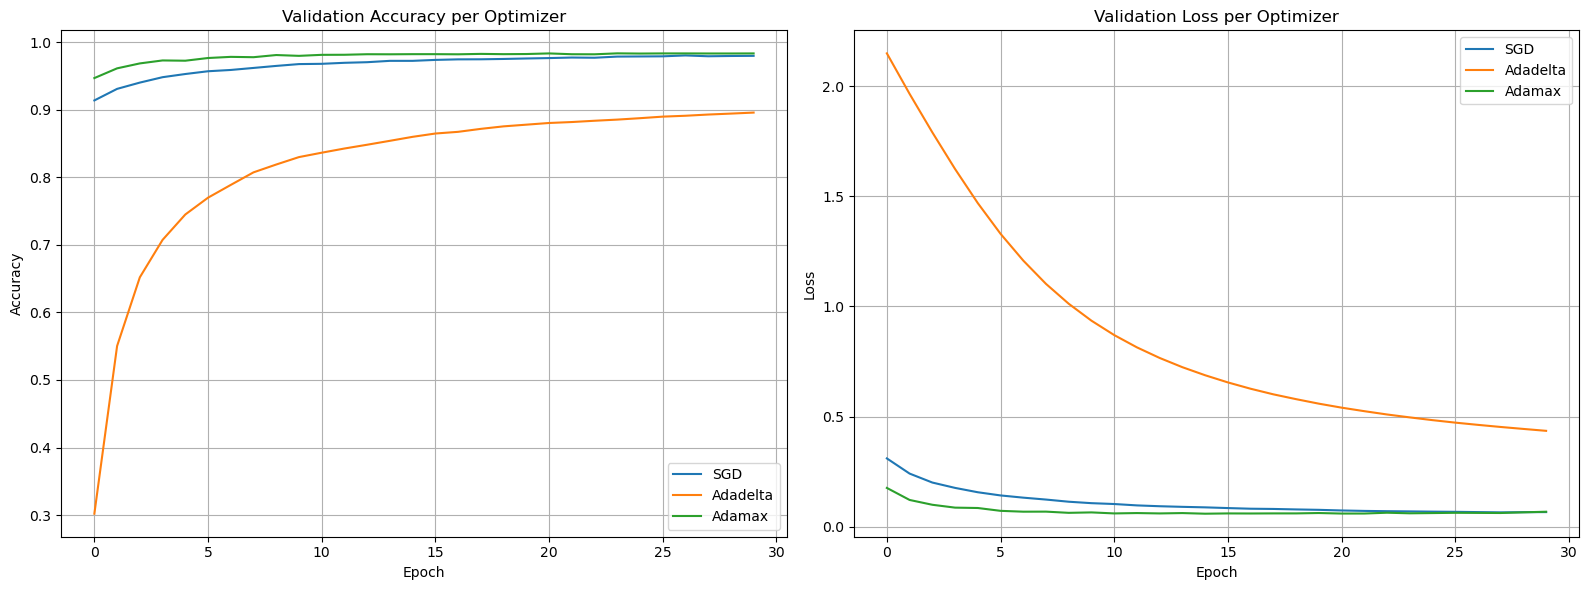

In [14]:
plt.figure(figsize=(16, 6))  # (larghezza, altezza) in pollici

# Grafico accuracy
plt.subplot(1, 2, 1)
for opt_name in histories:
    plt.plot(histories[opt_name].history['val_accuracy'], label=opt_name)
plt.title('Validation Accuracy per Optimizer')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()

# Grafico loss
plt.subplot(1, 2, 2)
for opt_name in histories:
    plt.plot(histories[opt_name].history['val_loss'], label=opt_name)
plt.grid(True)
plt.title('Validation Loss per Optimizer')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

Adamax sembra essere l'algoritmo vincente, quali possono essere i motivi?

1. Regola di aggiornamento pesi Adamax:

$
Δθ_i = - (learningrate / v_t) * m_t
$

Dove:

- v_t è il massimo storico dei gradienti (scalare)

- m_t è il momento primo (vettore)

Conseguenza: Tutti i parametri vengono normalizzati con lo stesso fattore v_t, ma:

I parametri con gradienti grandi ricevono aggiornamenti proporzionali alla loro importanza

I parametri con gradienti piccoli non vengono eccessivamente penalizzati

2. Natura dei Dati Immagine

    I pixel hanno valori in [0,1] con importanza variabile

    I pixel centrali e i bordi hanno potere predittivo diverso

In un layer fully connected per classificazione di cifre:
- I pixel correlati ai bordi della cifra hanno gradienti grandi
- I pixel dello sfondo hanno gradienti vicini a zero

3. Pattern di Gradienti Sparsi

    I layer convoluzionali producono pattern di attivazione sparsi

    Alcuni filtri si attivano solo su feature specifiche delle cifre

    Adamax eccelle negli scenari con gradienti sparsi

### Exercise 12.2


Medesimo problema, soluzione alternativa: CNN

In [18]:
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


Conv2D

MaxPoolin

Dropout


Flatten

In [20]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(6, kernel_size=(5, 5), strides=1,activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Conv2D(16, kernel_size=(5, 5), strides=1,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adamax',
                  metrics=['acc'])
    return model


Create and train Model:

In [22]:
# training parameters
batch_size = 32
epochs = 30

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history_CNN = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True, # per riorganizzare dati in modo randomico a ogni epoca
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.7103 - loss: 0.8865 - val_acc: 0.9553 - val_loss: 0.1465
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9353 - loss: 0.2189 - val_acc: 0.9698 - val_loss: 0.0974
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9521 - loss: 0.1644 - val_acc: 0.9756 - val_loss: 0.0766
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9592 - loss: 0.1360 - val_acc: 0.9782 - val_loss: 0.0671
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9635 - loss: 0.1226 - val_acc: 0.9813 - val_loss: 0.0579
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9674 - loss: 0.1073 - val_acc: 0.9822 - val_loss: 0.0536
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9708 - loss: 0.1022 - val_acc: 0.9836 - val_loss: 0.0500
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9732 - loss: 0.0917 - val_acc: 0.9840 - val_loss: 0.0481
Epoch 9/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/st

Eval model

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9877 - loss: 0.0372

Test loss: 0.029655419290065765
Test accuracy: 0.9896000027656555


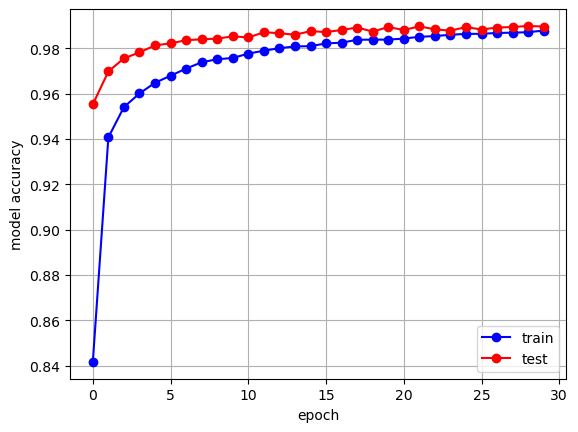

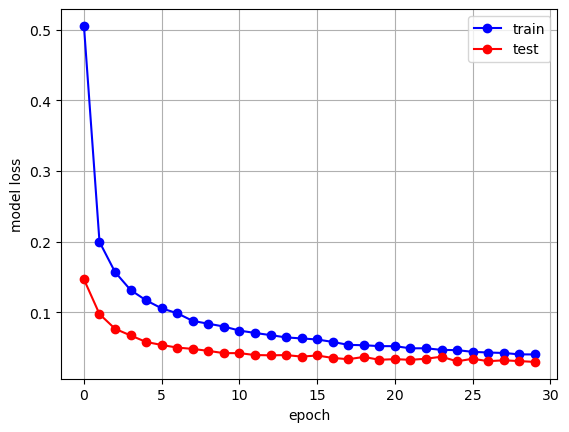

In [24]:
# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history_CNN.history['acc'], 'bo-')
plt.plot(history_CNN.history['val_acc'], 'ro-')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history_CNN.history['loss'], 'bo-')
plt.plot(history_CNN.history['val_loss'], 'ro-')
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='best')
plt.show()

Test e predictions:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


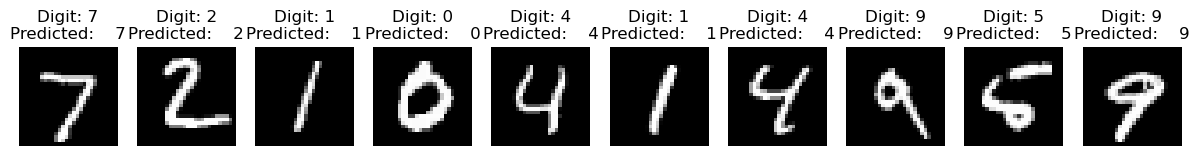

In [26]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

## Es. 12.3

Testiamo il funzionamento dei due modelli (DNN, CNN) su un dataset di cifre scritte manualmente:

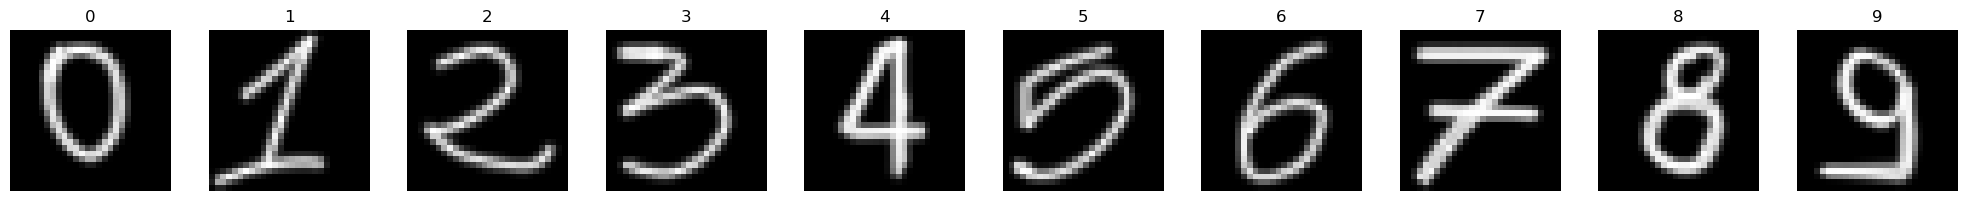

In [29]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

digit_images = []

# Carica le 10 immagini
for n in range(10):
    digit_filename = f"./numerini/{n}.png"
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
    pix = digit_in.load()
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i, j] = 255 - pix[j, i] #inverto
    data /= 255
    digit_images.append(data)

# Visualizza tutte le immagini in una sola riga
plt.figure(figsize=(20, 2))  # aumenta larghezza, altezza più bassa
for i in range(10):
    plt.subplot(1, 10, i + 1)  # 1 riga, 10 colonne
    plt.imshow(digit_images[i], cmap='gray')
    plt.axis('off')  # rimuove assi
    plt.title(f"{i}", fontsize=12)

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


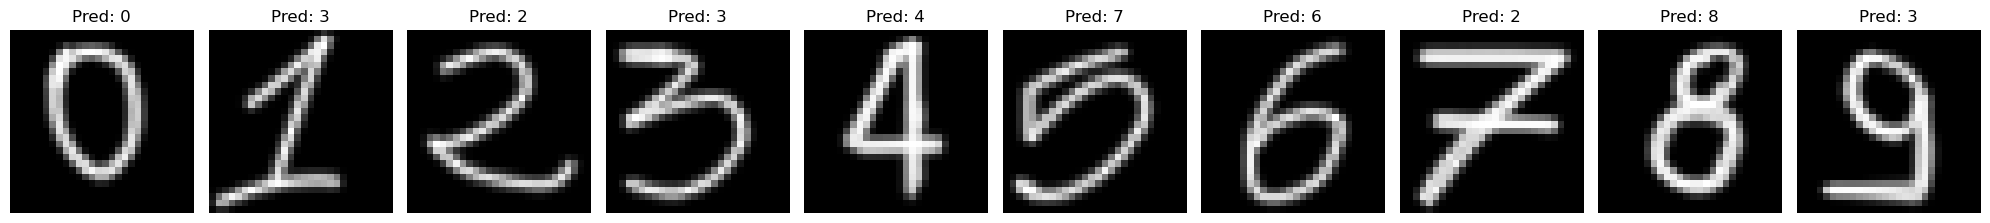

In [30]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

digit_images = []
image_vectors = []

# Carica e processa le immagini
for n in range(10):
    digit_filename = f"./numerini/{n}.png"
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
    pix = digit_in.load()
    
    # Crea immagine normalizzata
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i, j] = 255 - pix[j, i] #inverto
    data /= 255
    
    digit_images.append(data)                      # per visualizzazione
    image_vectors.append(data.reshape(-1))         # vettore 1D per DNN

# Convertili in array NumPy per batch prediction
X = np.array(image_vectors)  # shape: (10, xdim * ydim)

# Fai predizioni
predictions = model.predict(X)
predicted_digits = np.argmax(predictions, axis=1)

# Visualizza immagini con predizione
plt.figure(figsize=(20, 2.5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(digit_images[i], cmap='gray')
    plt.title(f"Pred: {predicted_digits[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Miglioramento delle Predizioni: Brush più Spesso

Le predizioni sopra mostrano alcune difficoltà del modello. Proviamo a modificare le immagini allargando il tratto per renderle più simili allo stile MNIST e vedere se le predizioni migliorano:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


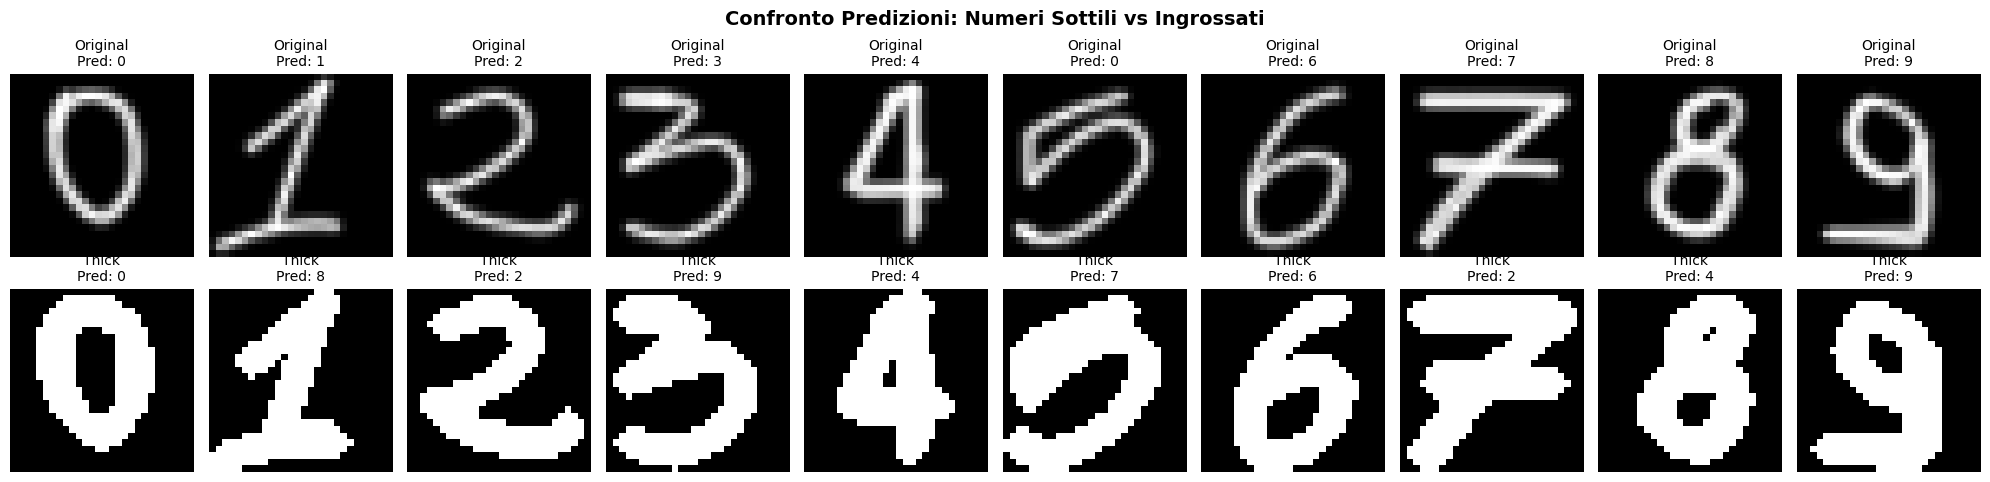

Confronto Predizioni:
Cifra | Originale | Ingrossata
------------------------------
  0   |     0 ✓   |     0 ✓
  1   |     1 ✓   |     8 ✗
  2   |     2 ✓   |     2 ✓
  3   |     3 ✓   |     9 ✗
  4   |     4 ✓   |     4 ✓
  5   |     0 ✗   |     7 ✗
  6   |     6 ✓   |     6 ✓
  7   |     7 ✓   |     2 ✗
  8   |     8 ✓   |     4 ✗
  9   |     9 ✓   |     9 ✓

Accuratezza:
Numeri originali: 9/10 (90%)
Numeri ingrossati: 5/10 (50%)


In [61]:
from scipy.ndimage import binary_dilation
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def thicken_image(image, iterations=2):
    """
    Allarga i tratti di un'immagine usando dilatazione morfologica
    """
    # Converte in binario (soglia a 0.1 per catturare anche tratti leggeri)
    binary = image > 0.1
    
    # Applica dilatazione per allargare i tratti
    thickened = binary_dilation(binary, iterations=iterations)
    
    # Riconverte a float [0,1]
    return thickened.astype(float)

# Carica e processa le immagini con brush allargato
digit_images_thick = []
cnn_input_images_thick = []

for n in range(10):
    digit_filename = f"./numerini/{n}.png"
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
    pix = digit_in.load()
    
    # Crea immagine normalizzata originale
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i, j] = 255 - pix[j, i]  # inverto nero-bianco
    data /= 255
    
    # Allarga il tratto
    data_thick = thicken_image(data, iterations=1)
    
    digit_images_thick.append(data_thick)
    
    # Prepara per CNN (aggiungi canale)
    data_cnn = data_thick.reshape(xdim, ydim, 1)
    cnn_input_images_thick.append(data_cnn)

# Convertili in array NumPy per batch prediction
X_thick = np.array(cnn_input_images_thick)

# Predizione con la CNN sui numeri ingrossati
predictions_thick = model_CNN.predict(X_thick)
predicted_digits_thick = np.argmax(predictions_thick, axis=1)

# Visualizza confronto: originali vs ingrossati
fig, axes = plt.subplots(2, 10, figsize=(20, 5))

# Riga superiore: numeri originali con predizioni originali  
for i in range(10):
    axes[0, i].imshow(digit_images[i], cmap='gray')
    axes[0, i].set_title(f"Original\nPred: {predicted_digits[i]}", fontsize=10)
    axes[0, i].axis('off')

# Riga inferiore: numeri ingrossati con nuove predizioni
for i in range(10):
    axes[1, i].imshow(digit_images_thick[i], cmap='gray')
    axes[1, i].set_title(f"Thick\nPred: {predicted_digits_thick[i]}", fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('Confronto Predizioni: Numeri Sottili vs Ingrossati', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Stampa confronto predizioni
print("Confronto Predizioni:")
print("Cifra | Originale | Ingrossata")
print("-" * 30)
for i in range(10):
    status_orig = "✓" if predicted_digits[i] == i else "✗"
    status_thick = "✓" if predicted_digits_thick[i] == i else "✗"
    print(f"  {i}   |     {predicted_digits[i]} {status_orig}   |     {predicted_digits_thick[i]} {status_thick}")

# Calcola accuratezza
correct_orig = sum(predicted_digits[i] == i for i in range(10))
correct_thick = sum(predicted_digits_thick[i] == i for i in range(10))

print(f"\nAccuratezza:")
print(f"Numeri originali: {correct_orig}/10 ({correct_orig*10}%)")
print(f"Numeri ingrossati: {correct_thick}/10 ({correct_thick*10}%)")